In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
!pip install timm torchmetrics grad-cam &> /dev/null

In [4]:
import os
import sys
import shutil
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy

import timm

from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import torch.optim as optim

from torchmetrics.classification import BinaryF1Score, BinaryAccuracy, BinarySpecificity

from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedGroupKFold


In [5]:
import tensorflow as tf
from tensorflow.keras.applications import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.preprocessing.image import *
from tensorflow.keras.utils import *
from sklearn.metrics import *
from collections import Counter
import cv2
import numpy as np
import pandas as pd
import seaborn as sn
#import preprocessing
from tqdm import tqdm
from io import BytesIO
from PIL import Image
from os import listdir
import matplotlib.pyplot as plt
from imageio import imread
from skimage.transform import resize
from sklearn.utils import compute_class_weight
from sklearn.model_selection import *
# import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from skimage.io import *
%config Completer.use_jedi = False
import warnings
warnings.filterwarnings('ignore')
print("All modules have been imported")

2023-03-07 13:57:15.158923: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-07 13:57:16.616925: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-07 13:57:29.932199: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /media/rohit/mirlproject2/rsna-breast-cancer-detection/rsna/lib/python3.8/site-packages

All modules have been imported


In [6]:
train_df = pd.read_csv('/media/rohit/mirlproject2/rsna-breast-cancer-detection/train.csv')

In [7]:
ddsm = train_df[['patient_id', 'image_id', 'cancer']]

In [8]:
img_folder= './archive/bc_1280_train_lut/'
ddsm['img_path_list'] = ddsm.apply(lambda x: img_folder+str(x.patient_id)+'_'+str(x.image_id)+'.png', axis = 1)

ddsm.tail(15)

,patient_id,image_id,cancer,img_path_list
54691,9968,2098937312,0,./archive/bc_1280_train_lut/9968_2098937312.png
54692,9968,294168046,0,./archive/bc_1280_train_lut/9968_294168046.png
54693,9968,568005453,0,./archive/bc_1280_train_lut/9968_568005453.png
54694,997,873425464,0,./archive/bc_1280_train_lut/997_873425464.png
54695,997,2129119612,0,./archive/bc_1280_train_lut/997_2129119612.png
54696,997,1487679918,0,./archive/bc_1280_train_lut/997_1487679918.png
54697,997,1775983513,0,./archive/bc_1280_train_lut/997_1775983513.png
54698,9973,1345265157,0,./archive/bc_1280_train_lut/9973_1345265157.png
54699,9973,1703611570,0,./archive/bc_1280_train_lut/9973_1703611570.png
54700,9973,655941939,0,./archive/bc_1280_train_lut/9973_655941939.png


In [9]:
# g = ddsm[:54705]

In [10]:
# g.tail(15)

In [11]:
print(ddsm.iloc[0])
ddsm.iloc[0]['img_path_list']

patient_id                                                 10006
image_id                                               462822612
cancer                                                         0
img_path_list    ./archive/bc_1280_train_lut/10006_462822612.png
Name: 0, dtype: object


'./archive/bc_1280_train_lut/10006_462822612.png'

In [12]:
from PIL import Image

img = Image.open(ddsm.iloc[17]['img_path_list'])
img=transforms.ToTensor()(img)
img.shape

torch.Size([1, 1280, 774])

In [13]:
images_list = ddsm['img_path_list']

In [14]:
images_list=list(images_list)

In [15]:
len(images_list)

54706

In [16]:
ddsm.sort_values('cancer', inplace =True)
ddsm

,patient_id,image_id,cancer,img_path_list
0,10006,462822612,0,./archive/bc_1280_train_lut/10006_462822612.png
36258,48921,1920949802,0,./archive/bc_1280_train_lut/48921_1920949802.png
36259,48939,105720752,0,./archive/bc_1280_train_lut/48939_105720752.png
36260,48939,441053398,0,./archive/bc_1280_train_lut/48939_441053398.png
36263,4894,368240487,0,./archive/bc_1280_train_lut/4894_368240487.png
...,...,...,...,...
17738,28747,1026238054,1,./archive/bc_1280_train_lut/28747_1026238054.png
17739,28747,2075658562,1,./archive/bc_1280_train_lut/28747_2075658562.png
29638,41610,1957729736,1,./archive/bc_1280_train_lut/41610_1957729736.png
8602,19182,1872087937,1,./archive/bc_1280_train_lut/19182_1872087937.png


In [17]:
ddsm['cancer'].sum()

1158

In [18]:
h = ddsm.iloc[54706-2316:]
h

,patient_id,image_id,cancer,img_path_list
17757,28766,1237905181,0,./archive/bc_1280_train_lut/28766_1237905181.png
17758,28766,1788400148,0,./archive/bc_1280_train_lut/28766_1788400148.png
17759,28766,1110412361,0,./archive/bc_1280_train_lut/28766_1110412361.png
17760,28766,1761592877,0,./archive/bc_1280_train_lut/28766_1761592877.png
17761,28768,724520365,0,./archive/bc_1280_train_lut/28768_724520365.png
...,...,...,...,...
17738,28747,1026238054,1,./archive/bc_1280_train_lut/28747_1026238054.png
17739,28747,2075658562,1,./archive/bc_1280_train_lut/28747_2075658562.png
29638,41610,1957729736,1,./archive/bc_1280_train_lut/41610_1957729736.png
8602,19182,1872087937,1,./archive/bc_1280_train_lut/19182_1872087937.png


In [19]:
class DDSMDataset(Dataset):
    def __init__(self, df, is_test=False, transform=None):

        self.images_list = df['img_path_list']
        self.images_list = list(self.images_list)
        self.labels_list = df['cancer']
        self.labels_list = list(self.labels_list)
        
        self.is_test = is_test
        self.transform = transform
        
    def __len__(self):
        return len(self.labels_list)
    
    def __getitem__(self, idx):
        if self.is_test:
            img = Image.open(self.images_list[idx])
            
        else:
            img = Image.open(self.images_list[idx])
        img = transforms.ToTensor()(img)
        if self.transform is not None:
            img = self.transform(img)
        #img = torch.permute(img, (2, 0, 1)) 
        img = transforms.Resize((512,512))(img)  
        img = img.repeat(3,1,1)
        if not self.is_test:
            target = self.labels_list[idx]
            return img, target
        #img = img.unsqueeze(0)
        
        return img, target

In [20]:
train_dataset = DDSMDataset(ddsm, is_test=False, transform=None)
# valid_dataset = DDSMDataset(images_list = x_val, labels_list = y_val, is_test=False, transform=None)
# test_dataset = DDSMDataset(images_list = x_test, labels_list = y_test, is_test=False, transform=None)
    
#train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
# val_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=16, shuffle=True)
len(train_dataset)

54706

In [21]:
train_dataset[-1]

(tensor([[[0.0000, 0.0000, 0.0000,  ..., 0.6456, 0.6840, 0.6866],
          [0.0000, 0.0000, 0.0000,  ..., 0.6957, 0.6816, 0.7270],
          [0.0000, 0.0000, 0.0000,  ..., 0.6824, 0.7318, 0.6877],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.6456, 0.6840, 0.6866],
          [0.0000, 0.0000, 0.0000,  ..., 0.6957, 0.6816, 0.7270],
          [0.0000, 0.0000, 0.0000,  ..., 0.6824, 0.7318, 0.6877],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],
 
         [[0.0000, 0.0000, 0.0000,  ..., 0.6456, 0.6840, 0.6866],
          [0.0000, 0.0000, 0.0000,  ..., 0.6957, 0.6816, 0.7270],
          [0.0000, 0.0000, 0.0000,  ...,

In [22]:
(train_dataset[11][0].shape)

torch.Size([3, 512, 512])

In [23]:
type(train_dataset)

__main__.DDSMDataset

In [25]:
import collections
from tqdm.notebook import tqdm_notebook

# get labels
# for _,y in tqdm()
y_train=[y for _,y in tqdm(train_dataset)]

# count labels
counter_train=collections.Counter(y_train)
print(counter_train)

100%|██████████| 54706/54706 [19:33<00:00, 46.61it/s]

Counter({0: 53548, 1: 1158})


In [26]:
# count_1=0
# count_0=0
# for _,y in tqdm_notebook(train_dataset):
#     if y==1:
#         count_1+=1
#     else:
#         count_0+=1

In [27]:
# count_1

In [28]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)

indices=list(range(len(train_dataset)))
#y_train0=[y for _,y in train_dataset]
for train_index, val_index in sss.split(indices, y_train):
    print("train:", train_index, "val:", val_index)
    print(len(train_index),len(val_index))

train: [18750 54408 10280 ... 31797 28183 51946] val: [31739 48410  3463 ...  3869  5534  6879]
43764 10942


In [29]:
from torch.utils.data import Subset

train_ds=Subset(train_dataset,train_index)
val_data=Subset(train_dataset,val_index)

In [30]:
print(len(train_ds))
print(len(val_data))

43764
10942


In [31]:
# y_train_ds=[y for _,y in tqdm_notebook(train_ds)]

# # count labels
# counter_train=collections.Counter(y_train_ds)
# print(counter_train)

In [33]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=0)

indices=list(range(len(val_data)))
y_val=[y for _,y in tqdm(val_data)]
for val_index, test_index in sss.split(indices, y_val):
    print("train:", val_index, "val:", test_index)
    print(len(val_index),len(test_index))

100%|██████████| 10942/10942 [02:10<00:00, 83.94it/s]

train: [4240 8240 9346 ... 3915 8934 8082] val: [6052  119 9137 ... 5464  585 6975]
9847 1095


In [34]:
val_ds=Subset(val_data,val_index)
test_ds=Subset(val_data,test_index)

In [35]:
print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

43764
9847
1095


In [36]:
# y_test=[y for _,y in test_ds]
# y_val=[y for _,y in val_ds]

# counter_test=collections.Counter(y_test)
# counter_val=collections.Counter(y_val)
# print(counter_test)
# print(counter_val)

image indices: [ 2732 43567 42613 21243]


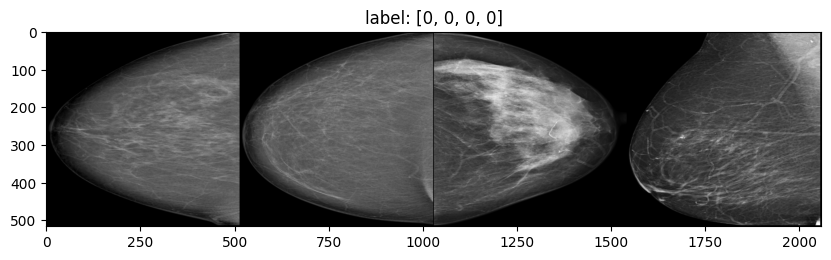

In [37]:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# fix random seed
np.random.seed(0)

def show(img,y=None,color=True):
    npimg = img.numpy()
    npimg_tr=np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)
    if y is not None:
        plt.title("label: "+str(y))
        
grid_size=4
rnd_inds=np.random.randint(0,len(train_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[train_ds[i][0] for i in rnd_inds]
y_grid=[train_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
#print(x_grid.shape)

# call helper function
plt.figure(figsize=(10,10))
show(x_grid,y_grid)

image indices: [2732 9845 3264 4859]


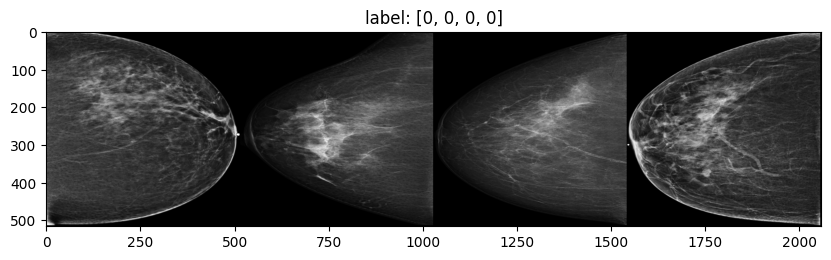

In [38]:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# fix random seed
np.random.seed(0)

def show(img,y=None,color=True):
    npimg = img.numpy()
    npimg_tr=np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)
    if y is not None:
        plt.title("label: "+str(y))
        
grid_size=4
rnd_inds=np.random.randint(0,len(val_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[val_ds[i][0] for i in rnd_inds]
y_grid=[val_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
#print(x_grid.shape)

# call helper function
plt.figure(figsize=(10,10))
show(x_grid,y_grid)

image indices: [684 559 835 763]


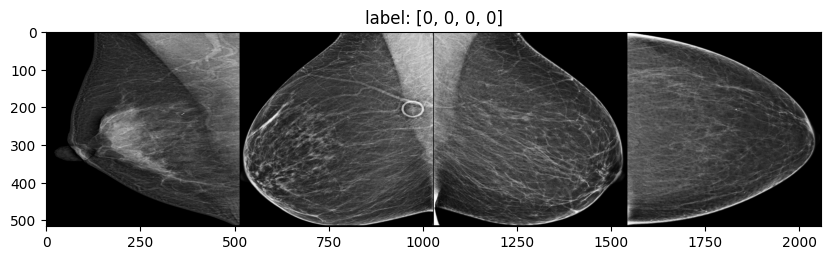

In [39]:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# fix random seed
np.random.seed(0)

def show(img,y=None,color=True):
    npimg = img.numpy()
    npimg_tr=np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)
    if y is not None:
        plt.title("label: "+str(y))
        
grid_size=4
rnd_inds=np.random.randint(0,len(test_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[test_ds[i][0] for i in rnd_inds]
y_grid=[test_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
#print(x_grid.shape)

# call helper function
plt.figure(figsize=(10,10))
show(x_grid,y_grid)

In [40]:
train_transformer = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  
    transforms.RandomVerticalFlip(p=0.5),  
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
    transforms.Normalize((0.5,), (0.5,))])
                 

test0_transformer = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.cat([x, x, x], 0)),
    transforms.Normalize((0.5,), (0.5,)),
    ])

In [41]:
train_ds.transform=train_transformer
val_data.transform=test0_transformer

image indices: [ 2732 43567 42613 21243]


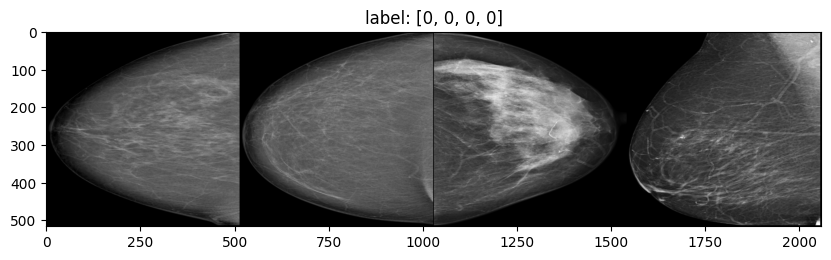

In [42]:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# fix random seed
np.random.seed(0)

def show(img,y=None,color=True):
    npimg = img.numpy()
    npimg_tr=np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)
    if y is not None:
        plt.title("label: "+str(y))
        
grid_size=4
rnd_inds=np.random.randint(0,len(train_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[train_ds[i][0] for i in rnd_inds]
y_grid=[train_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
#print(x_grid.shape)

# call helper function
plt.figure(figsize=(10,10))
show(x_grid,y_grid)

image indices: [2732 9845 3264 4859]


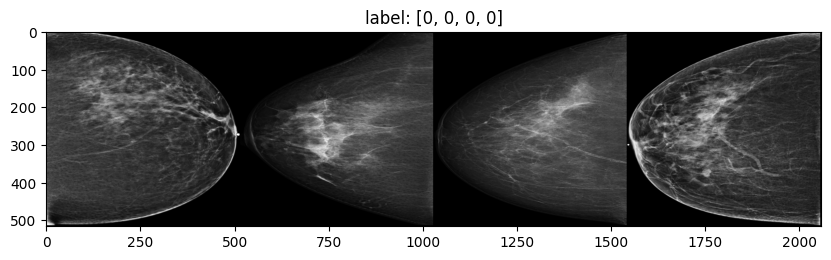

In [43]:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# fix random seed
np.random.seed(0)

def show(img,y=None,color=True):
    npimg = img.numpy()
    npimg_tr=np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)
    if y is not None:
        plt.title("label: "+str(y))
        
grid_size=4
rnd_inds=np.random.randint(0,len(val_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[val_ds[i][0] for i in rnd_inds]
y_grid=[val_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
#print(x_grid.shape)

# call helper function
plt.figure(figsize=(10,10))
show(x_grid,y_grid)

image indices: [684 559 835 763]


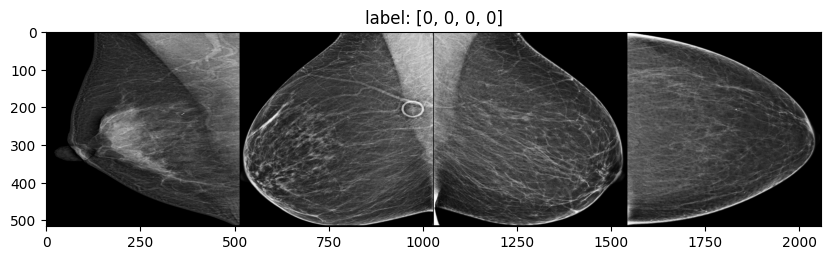

In [44]:
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# fix random seed
np.random.seed(0)

def show(img,y=None,color=True):
    npimg = img.numpy()
    npimg_tr=np.transpose(npimg, (1,2,0))
    plt.imshow(npimg_tr)
    if y is not None:
        plt.title("label: "+str(y))
        
grid_size=4
rnd_inds=np.random.randint(0,len(test_ds),grid_size)
print("image indices:",rnd_inds)

x_grid=[test_ds[i][0] for i in rnd_inds]
y_grid=[test_ds[i][1] for i in rnd_inds]

x_grid=utils.make_grid(x_grid, nrow=4, padding=2)
#print(x_grid.shape)

# call helper function
plt.figure(figsize=(10,10))
show(x_grid,y_grid)

In [45]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, batch_size=16, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=16, shuffle=False) 

In [46]:
for x, y in train_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([16, 3, 512, 512])
torch.Size([16])


In [47]:
for x, y in val_dl:
    print(x.shape)
    print(y.shape)
    break

torch.Size([16, 3, 512, 512])
torch.Size([16])


In [48]:
from torchvision import models
import torch
from torch import nn

# load model with pretrained weights
densenet121_pretrained = models.densenet121(pretrained=True)
densenet121_pretrained.load_state_dict(torch.load('./densenet121_pretrained_abhishek_expt1 (copy).pt', map_location =torch.device('cuda')))

In [49]:
densenet121_pretrained

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [50]:
# densenet121_pretrained.features.conv0

In [51]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# densenet121_pretrained.features.conv0=nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
densenet121_pretrained.classifier = nn.Sequential(nn.Linear(1024,2)) # ResNet50
densenet121_pretrained = densenet121_pretrained.to(device)

In [52]:
densenet121_pretrained

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [53]:
for x,y in train_dl:
    print(x.shape)
    break
  
densenet121_pretrained(x.cuda()).shape

torch.Size([16, 3, 512, 512])


torch.Size([16, 2])

In [54]:
!nvidia-smi

Tue Mar  7 14:24:03 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.161.03   Driver Version: 470.161.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 N/A |                  N/A |
| 40%   61C    P0    N/A /  N/A |   1113MiB /  1999MiB |     N/A      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA GeForce ...  Off  | 00000000:04:00.0 Off |                  N/A |
|  0%   

In [55]:
def metrics_batch(output, target):
    # get output class
    pred = output.argmax(dim=1, keepdim=True)
    
    # compare output class with target class
    corrects=pred.eq(target.view_as(pred)).sum().item()
    return corrects

In [56]:
device

device(type='cuda')

In [57]:
def loss_batch(loss_func, output, target, opt=None):
    
    # get loss 
    loss = loss_func(output, target)
    
    # get performance metric
    metric_b = metrics_batch(output,target)
    
    if opt is not None:
        opt.zero_grad()
        loss.backward()
        opt.step()

    return loss.item(), metric_b

In [58]:
def loss_epoch(model,loss_func,dataset_dl,opt=None):
    running_loss=0.0
    running_metric=0.0
    len_data=len(dataset_dl.dataset)

    for xb, yb in tqdm(dataset_dl):
        # move batch to device
        xb=xb.to(device)
        yb=yb.to(device)
        
        # get model output
        output=model(xb)
        
        # get loss per batch
        loss_b,metric_b=loss_batch(loss_func, output, yb, opt)
        
        # update running loss
        running_loss+=loss_b
        
        # update running metric
        if metric_b is not None:
            running_metric+=metric_b
    
    # average loss value
    loss=running_loss/float(len_data)
    
    # average metric value
    metric=running_metric/float(len_data)
    
    return loss, metric

In [59]:
import copy

def train_val(model, params):
    # extract model parameters
    num_epochs=params["num_epochs"]
    loss_func=params["loss_func"]
    opt=params["optimizer"]
    train_dl=params["train_dl"]
    val_dl=params["val_dl"]
    path2weights=params["path2weights"]
    
    # history of loss values in each epoch
    loss_history={
        "train": [],
        "val": [],
    }
    
    # histroy of metric values in each epoch
    metric_history={
        "train": [],
        "val": [],
    }
    
    # a deep copy of weights for the best performing model
    best_model_wts = copy.deepcopy(model.state_dict())
    
    # initialize best loss to a large value
    best_loss=float('inf')
    
    # main loop
    for epoch in tqdm(range(num_epochs)):
        
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        
        # train model on training dataset
        model.train()
        train_loss, train_metric=loss_epoch(model,loss_func,train_dl,opt)

        # collect loss and metric for training dataset
        loss_history["train"].append(train_loss)
        metric_history["train"].append(train_metric)
        
        # evaluate model on validation dataset    
        model.eval()
        with torch.no_grad():
            val_loss, val_metric=loss_epoch(model,loss_func,val_dl)
        
       
        # store best model
        if val_loss < best_loss:
            best_loss = val_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            
            # store weights into a local file
            torch.save(model.state_dict(), path2weights)
            print("Copied best model weights!")
        
        # collect loss and metric for validation dataset
        loss_history["val"].append(val_loss)
        metric_history["val"].append(val_metric)
        

        print("train loss: %.6f, dev loss: %.6f, accuracy: %.2f" %(train_loss,val_loss,100*val_metric))
        print("-"*10) 

    # load best model weights
    model.load_state_dict(best_model_wts)
        
    return model, loss_history, metric_history

In [60]:
device

device(type='cuda')

In [61]:
from torch import optim

loss_func = nn.CrossEntropyLoss(reduction="sum")
opt = optim.Adam(densenet121_pretrained.parameters(), lr=1e-4)

params_train={
 "num_epochs": 20,
 "optimizer": opt,
 "loss_func": loss_func,
 "train_dl": train_dl,
 "val_dl": val_dl,
 "path2weights": "./densenet121_pretrained_abhishek_expt1.pt",
}

# train and validate the model
densenet121_pretrained,loss_hist,metric_hist=train_val(densenet121_pretrained,params_train)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20


  5%|▌         | 1/20 [33:06<10:29:05, 1986.59s/it]

Copied best model weights!
train loss: 0.104397, dev loss: 0.101229, accuracy: 97.80
----------
Epoch 2/20


 10%|█         | 2/20 [1:02:49<9:20:05, 1866.97s/it]

Copied best model weights!
train loss: 0.099870, dev loss: 0.100321, accuracy: 97.88
----------
Epoch 3/20


 15%|█▌        | 3/20 [1:29:45<8:16:29, 1752.30s/it]

Copied best model weights!
train loss: 0.097025, dev loss: 0.096478, accuracy: 97.89
----------
Epoch 4/20


 20%|██        | 4/20 [1:56:28<7:31:32, 1693.29s/it]

train loss: 0.093352, dev loss: 0.097934, accuracy: 97.91
----------
Epoch 5/20


 25%|██▌       | 5/20 [2:20:53<6:42:45, 1611.01s/it]

train loss: 0.087470, dev loss: 0.126914, accuracy: 96.60
----------
Epoch 6/20


 30%|███       | 6/20 [2:41:29<5:46:09, 1483.52s/it]

train loss: 0.078866, dev loss: 0.102537, accuracy: 97.59
----------
Epoch 7/20


 35%|███▌      | 7/20 [3:00:38<4:57:44, 1374.22s/it]

train loss: 0.064272, dev loss: 0.104891, accuracy: 97.85
----------
Epoch 8/20


 40%|████      | 8/20 [3:19:50<4:20:38, 1303.21s/it]

train loss: 0.048542, dev loss: 0.143732, accuracy: 96.50
----------
Epoch 9/20


 45%|████▌     | 9/20 [3:38:58<3:50:02, 1254.73s/it]

train loss: 0.035873, dev loss: 0.135488, accuracy: 97.24
----------
Epoch 10/20


 50%|█████     | 10/20 [3:57:52<3:22:56, 1217.69s/it]

train loss: 0.028015, dev loss: 0.132492, accuracy: 97.72
----------
Epoch 11/20


 55%|█████▌    | 11/20 [4:16:44<2:58:42, 1191.44s/it]

train loss: 0.021335, dev loss: 0.134800, accuracy: 97.47
----------
Epoch 12/20


 60%|██████    | 12/20 [4:35:36<2:36:26, 1173.36s/it]

train loss: 0.018468, dev loss: 0.157591, accuracy: 97.52
----------
Epoch 13/20


 65%|██████▌   | 13/20 [4:54:28<2:15:24, 1160.69s/it]

train loss: 0.014974, dev loss: 0.159229, accuracy: 97.86
----------
Epoch 14/20


 70%|███████   | 14/20 [5:13:20<1:55:12, 1152.08s/it]

train loss: 0.013045, dev loss: 0.161614, accuracy: 97.42
----------
Epoch 15/20


 75%|███████▌  | 15/20 [5:32:12<1:35:30, 1146.13s/it]

train loss: 0.013498, dev loss: 0.159011, accuracy: 97.57
----------
Epoch 16/20


 80%|████████  | 16/20 [5:51:04<1:16:06, 1141.74s/it]

train loss: 0.011011, dev loss: 0.173757, accuracy: 97.80
----------
Epoch 17/20


 85%|████████▌ | 17/20 [6:09:56<56:56, 1138.83s/it]  

train loss: 0.009218, dev loss: 0.174120, accuracy: 97.76
----------
Epoch 18/20


 90%|█████████ | 18/20 [6:28:48<37:53, 1136.73s/it]

train loss: 0.009297, dev loss: 0.179321, accuracy: 97.53
----------
Epoch 19/20


 95%|█████████▌| 19/20 [6:47:40<18:55, 1135.28s/it]

train loss: 0.008534, dev loss: 0.186444, accuracy: 97.61
----------
Epoch 20/20


100%|██████████| 20/20 [7:06:31<00:00, 1279.60s/it]


train loss: 0.008440, dev loss: 0.185776, accuracy: 97.64
----------


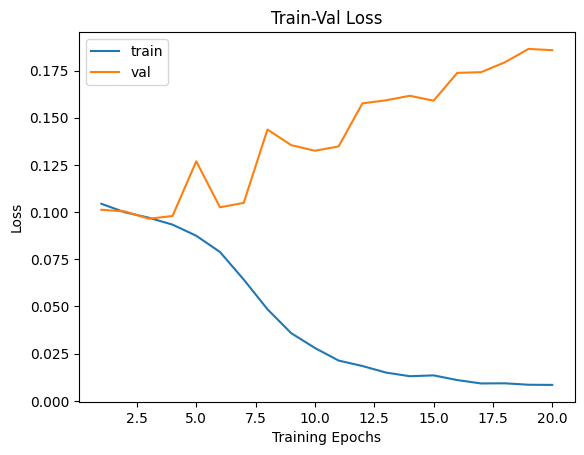

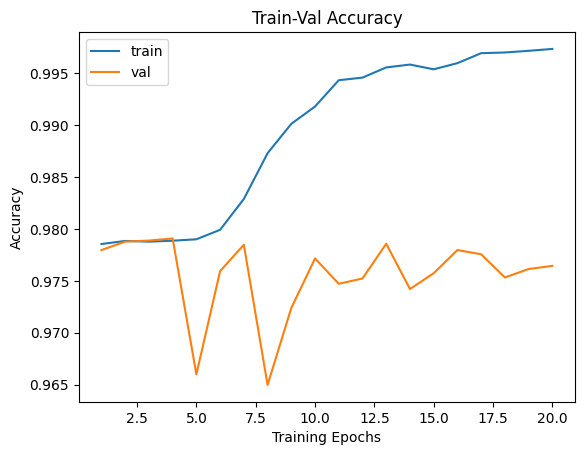

In [62]:
# Train-Validation Progress
num_epochs=params_train["num_epochs"]

# plot loss progress
plt.title("Train-Val Loss")
plt.plot(range(1,num_epochs+1),loss_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),loss_hist["val"],label="val")
plt.ylabel("Loss")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

# plot accuracy progress
plt.title("Train-Val Accuracy")
plt.plot(range(1,num_epochs+1),metric_hist["train"],label="train")
plt.plot(range(1,num_epochs+1),metric_hist["val"],label="val")
plt.ylabel("Accuracy")
plt.xlabel("Training Epochs")
plt.legend()
plt.show()

In [63]:
densenet121_pretrained.load_state_dict(torch.load('./densenet121_pretrained_abhishek_expt1.pt', map_location =torch.device('cuda')))

<All keys matched successfully>

In [64]:
densenet121_pretrained.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [65]:
def deploy_model(model,dataset,device,num_classes=2):
  len_data=len(dataset)
  y_out=torch.zeros(len_data,num_classes)
  y_gt=np.zeros((len_data),dtype="uint8")
  with torch.no_grad():
    for i in range(len_data):
      x,y=dataset[i]
      y_gt[i]=y
      yy=model(x.unsqueeze(0).to(device))
      y_out[i]=torch.softmax(yy,dim=1)
  return y_out.numpy(),y_gt

In [66]:
y_out,y_gt=deploy_model(densenet121_pretrained,test_ds,device=device)

In [67]:
unique, counts = np.unique(y_gt, return_counts=True)
dict(zip(unique, counts))

{0: 1072, 1: 23}

In [68]:
y_pred = np.argmax(y_out,axis=1)

In [69]:
unique, counts = np.unique(y_pred, return_counts=True)
dict(zip(unique, counts))

{0: 1094, 1: 1}

In [70]:
len(test_ds)

1095

In [71]:
from sklearn import metrics
print('Accuracy:', np.round(metrics.accuracy_score(y_gt, y_pred),5))
print('Precision:', np.round(metrics.precision_score(y_gt, y_pred, average='weighted'),5))
print('Recall:', np.round(metrics.recall_score(y_gt,y_pred, average='weighted'),5))
print('F1 Score:', np.round(metrics.f1_score(y_gt, y_pred, average='weighted'),5))

Accuracy: 0.97991
Precision: 0.98031
Recall: 0.97991
F1 Score: 0.9708


In [72]:
target=['0','1']
print('\t\tClassification Report:\n', metrics.classification_report(y_gt, y_pred,target_names=target))

		Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1072
           1       1.00      0.04      0.08        23

    accuracy                           0.98      1095
   macro avg       0.99      0.52      0.54      1095
weighted avg       0.98      0.98      0.97      1095

